### Insurance Claims - Fraud Detection
`Business case:`
*Insurance fraud is a huge problem in the industry. It's difficult to identify fraud claims. IHS is in a unique position to help the Auto Insurance industry with this problem.*
- Data Acquisition and loading
- Initial Exploration
- Data Cleaning & Pre-processing
- Exploratory Data Analysis (EDA)
- Feature Engineering & Selection
- Modeling
- Model Evaluation
- Model Interpretation
- Deployment & Prediction with Unseen & synthetic data

`Approach:`As we are working with some auto insurance data to demonstrate how we can create a predictive model that predicts if an insurance claim is fraudulent or not. This will be a Binary Classification task, and will be creating a Decision Tree model.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, make_scorer
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import SMOTE
import shap
import joblib
import warnings

**What to Use, When to Use, and Why to Use (for Key ML Libraries)**

---

1. **Data Splitting**
**`from sklearn.model_selection import train_test_split`**
- **What:** Splits your dataset into training and testing (and optionally validation) sets.
- **When:** Always use before training any model to evaluate performance on unseen data.
- **Why:** Prevents overfitting and ensures your model generalizes well.

---

2. **Data Preprocessing**
**`from sklearn.preprocessing import StandardScaler, LabelEncoder`**
- **StandardScaler**
  - **What:** Scales numerical features to have zero mean and unit variance.
  - **When:** Use for algorithms sensitive to feature scale (e.g., SVM, KNN, Logistic Regression).
  - **Why:** Improves convergence and performance for many models.
- **LabelEncoder**
  - **What:** Converts categorical string labels into integers.
  - **When:** Use for encoding target variables or categorical features for tree-based models.
  - **Why:** Machine learning models require numeric input.

---

3. **Model Selection**
**`from sklearn.ensemble import RandomForestClassifier`**
- **What:** An ensemble tree-based classifier.
- **When:** Use for classification tasks, especially with mixed or categorical data.
- **Why:** Handles non-linearities, robust to outliers, provides feature importance.

**`from sklearn.svm import SVC`**
- **What:** Support Vector Machine classifier.
- **When:** Use for classification with small-to-medium datasets and well-scaled features.
- **Why:** Effective for high-dimensional spaces, can model non-linear boundaries.

---

4. **Model Evaluation**
**`from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve`**
- **classification_report**
  - **What:** Shows precision, recall, f1-score, and support for each class.
  - **When:** After predictions, to evaluate model performance.
  - **Why:** Gives a detailed breakdown of classification metrics.
- **confusion_matrix**
  - **What:** Displays true/false positives/negatives.
  - **When:** To visualize prediction errors.
  - **Why:** Helps understand types of errors made by the model.
- **roc_auc_score, roc_curve**
  - **What:** Measures and plots the area under the ROC curve.
  - **When:** For binary classification, especially with imbalanced data.
  - **Why:** Evaluates model's ability to distinguish between classes.

---

5. **Feature Selection**
**`from sklearn.feature_selection import RFECV`**
- **What:** Recursive Feature Elimination with Cross-Validation.
- **When:** To select the most important features before modeling.
- **Why:** Reduces overfitting, improves model interpretability and performance.

---

6. **Handling Imbalanced Data**
**`from imblearn.over_sampling import SMOTE`**
- **What:** Synthetic Minority Over-sampling Technique.
- **When:** When your dataset has imbalanced classes.
- **Why:** Balances the class distribution by generating synthetic samples for the minority class.

---

7. **Model Explainability**
**`import shap`**
- **What:** SHapley Additive exPlanations for model interpretability.
- **When:** After training, to explain individual predictions or global feature importance.
- **Why:** Provides insights into how features impact model predictions.

---

8. **Model Persistence**
**`import joblib`**
- **What:** Library for saving and loading Python objects (models, preprocessors, etc.).
- **When:** After training, to save your model for later use or deployment.
- **Why:** Efficiently serializes large numpy arrays and scikit-learn models.

---

In [3]:
warnings.filterwarnings("ignore")

In [4]:
df1 = pd.read_csv('insurance_claims.csv')

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
df1.columns

Index(['months_as_customer', 'age', 'policy_number', 'policy_bind_date',
       'policy_state', 'policy_csl', 'policy_deductable',
       'policy_annual_premium', 'umbrella_limit', 'insured_zip', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'capital-gains', 'capital-loss',
       'incident_date', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'injury_claim', 'property_claim', 'vehicle_claim', 'auto_make',
       'auto_model', 'auto_year', 'fraud_reported'],
      dtype='object')

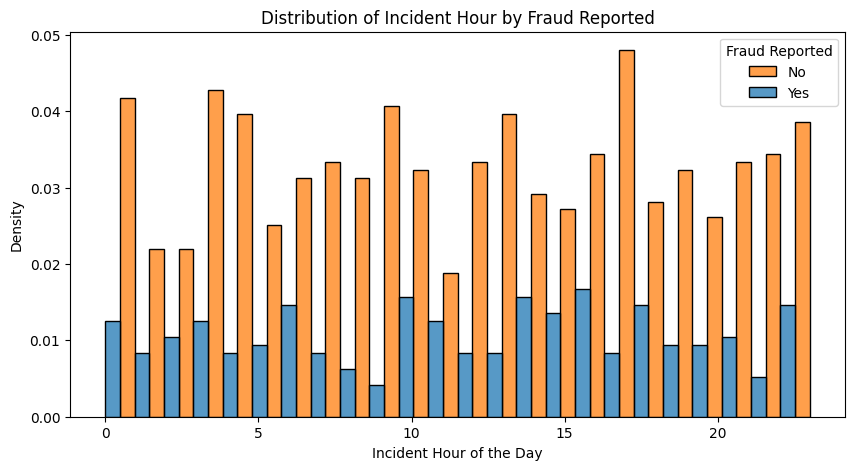

In [7]:
plt.figure(figsize=(10, 5))
sns.histplot(
    data=df1,
    x='incident_hour_of_the_day',
    hue='fraud_reported',
    bins=24,
    multiple='dodge',
    stat='density'
)
plt.title('Distribution of Incident Hour by Fraud Reported')
plt.xlabel('Incident Hour of the Day')
plt.ylabel('Density')
plt.legend(title='Fraud Reported', labels=['No', 'Yes'])
plt.show()

In [8]:
df1 = df1.drop(columns=['policy_number', 'policy_bind_date', 'insured_zip', 'incident_date', 'incident_location'])
# In summary, these distinct columns are dropped because they have distinct values, high-cardinality, or not directly useful for modeling. This helps reduce noise and the risk of overfitting..

In [9]:
df1.head()

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,OH,250/500,1000,1406.91,0,MALE,MD,craft-repair,sleeping,husband,53300,0,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,IN,250/500,2000,1197.22,5000000,MALE,MD,machine-op-inspct,reading,other-relative,0,0,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,OH,100/300,2000,1413.14,5000000,FEMALE,PhD,sales,board-games,own-child,35100,0,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,IL,250/500,2000,1415.74,6000000,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,IL,500/1000,1000,1583.91,6000000,MALE,Associate,sales,board-games,unmarried,66000,-46000,Vehicle Theft,?,Minor Damage,NaN,NY,Arlington,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [10]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 34 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_state                 1000 non-null   object 
 3   policy_csl                   1000 non-null   object 
 4   policy_deductable            1000 non-null   int64  
 5   policy_annual_premium        1000 non-null   float64
 6   umbrella_limit               1000 non-null   int64  
 7   insured_sex                  1000 non-null   object 
 8   insured_education_level      1000 non-null   object 
 9   insured_occupation           1000 non-null   object 
 10  insured_hobbies              1000 non-null   object 
 11  insured_relationship         1000 non-null   object 
 12  capital-gains                1000 non-null   int64  
 13  capital-loss       

In [11]:
for i in df1.columns:
    df1[i].replace("?",np.nan,inplace=True)
df1.head()

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,OH,250/500,1000,1406.91,0,MALE,MD,craft-repair,sleeping,husband,53300,0,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,IN,250/500,2000,1197.22,5000000,MALE,MD,machine-op-inspct,reading,other-relative,0,0,Vehicle Theft,NaN,Minor Damage,Police,VA,Riverwood,8,1,NaN,0,0,NaN,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,OH,100/300,2000,1413.14,5000000,FEMALE,PhD,sales,board-games,own-child,35100,0,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,IL,250/500,2000,1415.74,6000000,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,5,1,NaN,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y
4,228,44,IL,500/1000,1000,1583.91,6000000,MALE,Associate,sales,board-games,unmarried,66000,-46000,Vehicle Theft,NaN,Minor Damage,NaN,NY,Arlington,20,1,NO,0,1,NO,6500,1300,650,4550,Accura,RSX,2009,N


In [12]:
print(df1.isnull().sum())

months_as_customer               0
age                              0
policy_state                     0
policy_csl                       0
policy_deductable                0
policy_annual_premium            0
umbrella_limit                   0
insured_sex                      0
insured_education_level          0
insured_occupation               0
insured_hobbies                  0
insured_relationship             0
capital-gains                    0
capital-loss                     0
incident_type                    0
collision_type                 178
incident_severity                0
authorities_contacted           91
incident_state                   0
incident_city                    0
incident_hour_of_the_day         0
number_of_vehicles_involved      0
property_damage                360
bodily_injuries                  0
witnesses                        0
police_report_available        343
total_claim_amount               0
injury_claim                     0
property_claim      

In [13]:
print(df1['fraud_reported'].value_counts())

fraud_reported
N    753
Y    247
Name: count, dtype: int64


In [14]:
# performing imputation of missing values
## Impute missing values for categorical columns with 'Unknown' because mode is used for randomness or where missing values are meaningless
for col in ['collision_type', 'authorities_contacted', 'property_damage']:
    df1[col].fillna('Unknown', inplace=True)

In [15]:
# print(df1.isnull().sum())

In [16]:
# Encode binary categorical cols: YES=1, NO=0, Unknown=-1
df1['property_damage'] = df1['property_damage'].map({'YES': 1, 'NO': 0, 'Unknown': -1})
df1['police_report_available'] = df1['police_report_available'].map({'YES': 1, 'NO': 0, 'Unknown': -1})

In [17]:
# Encode target col: Y=1, N=0
df1['fraud_reported'] = df1['fraud_reported'].map({'Y': 1, 'N': 0})

In [18]:
df1.sample(5)

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
865,218,43,IL,250/500,500,1521.55,0,FEMALE,Associate,priv-house-serv,polo,other-relative,61100,-64500,Single Vehicle Collision,Rear Collision,Major Damage,Fire,SC,Hillsdale,18,1,-1,1,3,1.0,68200,13640,6820,47740,Dodge,RAM,2003,1
272,332,47,IL,100/300,2000,1083.01,0,MALE,MD,craft-repair,paintball,other-relative,91900,0,Multi-vehicle Collision,Front Collision,Major Damage,Police,WV,Arlington,22,4,1,2,0,NaN,71760,11040,11040,49680,Jeep,Grand Cherokee,2010,1
481,20,21,OH,250/500,1000,1390.29,0,FEMALE,Masters,priv-house-serv,polo,other-relative,0,-41200,Single Vehicle Collision,Rear Collision,Minor Damage,Fire,PA,Northbrook,14,1,0,0,0,NaN,62900,12580,6290,44030,Accura,MDX,2006,0
282,201,40,OH,250/500,2000,1315.56,0,FEMALE,PhD,transport-moving,video-games,not-in-family,0,0,Vehicle Theft,Unknown,Minor Damage,Police,SC,Northbrook,14,1,1,0,0,1.0,6820,1240,1240,4340,Jeep,Grand Cherokee,2003,0
359,292,44,OH,500/1000,500,1097.57,0,MALE,PhD,priv-house-serv,basketball,unmarried,0,0,Single Vehicle Collision,Side Collision,Total Loss,Other,SC,Columbus,12,1,0,1,0,1.0,61700,6170,6170,49360,Saab,93,2005,0


In [19]:
df1.shape

(1000, 34)

In [20]:
remaining_cat_cols = df1.select_dtypes(include='object').columns
print(remaining_cat_cols)
print(df1.dtypes)

Index(['policy_state', 'policy_csl', 'insured_sex', 'insured_education_level',
       'insured_occupation', 'insured_hobbies', 'insured_relationship',
       'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city', 'auto_make',
       'auto_model'],
      dtype='object')
months_as_customer               int64
age                              int64
policy_state                    object
policy_csl                      object
policy_deductable                int64
policy_annual_premium          float64
umbrella_limit                   int64
insured_sex                     object
insured_education_level         object
insured_occupation              object
insured_hobbies                 object
insured_relationship            object
capital-gains                    int64
capital-loss                     int64
incident_type                   object
collision_type                  object
incident_severity               object

*Data Processing Summary*: 
- `Binary categorical cols mapped to respective yes:1, no:0, unknown:-1` as extra unknown value is crucial to train the model for detecting fraud cases
- `Target col 'fraud_reported' mapped to Y:1, N:0`
- `cat_cols encoded to numeric labels using Label Encoding` necessary for tree-based models

In [21]:
cat_cols = [
    'collision_type', 'authorities_contacted', 'insured_sex', 'insured_education_level',
    'insured_occupation', 'insured_hobbies', 'insured_relationship', 'incident_type',
    'incident_severity', 'auto_make', 'auto_model', 'policy_state', 'policy_csl',
    'incident_state', 'incident_city'
]

le = LabelEncoder()
label_maps = {}

for col in cat_cols:
    df1[col] = le.fit_transform(df1[col].astype(str))
    # mapping documentation
    label_maps[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# maps for each column
for col, map in label_maps.items():
    print(f"Label encoding for {col}: {map}")

Label encoding for collision_type: {'Front Collision': 0, 'Rear Collision': 1, 'Side Collision': 2, 'Unknown': 3}
Label encoding for authorities_contacted: {'Ambulance': 0, 'Fire': 1, 'Other': 2, 'Police': 3, 'Unknown': 4}
Label encoding for insured_sex: {'FEMALE': 0, 'MALE': 1}
Label encoding for insured_education_level: {'Associate': 0, 'College': 1, 'High School': 2, 'JD': 3, 'MD': 4, 'Masters': 5, 'PhD': 6}
Label encoding for insured_occupation: {'adm-clerical': 0, 'armed-forces': 1, 'craft-repair': 2, 'exec-managerial': 3, 'farming-fishing': 4, 'handlers-cleaners': 5, 'machine-op-inspct': 6, 'other-service': 7, 'priv-house-serv': 8, 'prof-specialty': 9, 'protective-serv': 10, 'sales': 11, 'tech-support': 12, 'transport-moving': 13}
Label encoding for insured_hobbies: {'base-jumping': 0, 'basketball': 1, 'board-games': 2, 'bungie-jumping': 3, 'camping': 4, 'chess': 5, 'cross-fit': 6, 'dancing': 7, 'exercise': 8, 'golf': 9, 'hiking': 10, 'kayaking': 11, 'movies': 12, 'paintball': 13

In [22]:
df2 = df1.copy()

In [23]:
df2.sample(5)

,months_as_customer,age,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
329,78,31,1,1,1000,1554.64,4000000,1,6,10,2,3,0,-27900,2,0,0,2,6,6,21,1,0,1,0,0.0,55660,5060,10120,40480,6,8,2009,1
613,75,27,1,1,1000,1202.75,0,1,2,5,2,1,57900,-90100,0,0,1,3,4,4,23,3,0,0,2,1.0,79560,6630,13260,59670,13,28,2003,0
388,208,36,2,0,2000,1209.41,5000000,1,3,6,0,5,0,0,0,2,2,2,1,1,15,3,1,0,1,NaN,62810,11420,11420,39970,9,35,1999,0
226,371,52,0,1,1000,1242.96,7000000,0,2,7,13,3,0,-37100,0,1,1,2,1,5,2,2,1,2,0,NaN,88920,6840,13680,68400,0,31,2010,0
861,212,40,0,2,1000,1524.45,0,0,5,7,9,0,73200,0,0,2,1,2,1,4,17,3,1,0,2,1.0,82400,8240,8240,65920,9,29,2006,0


In [24]:
# print(df2.shape)
# print(df2.info())

Optimal number of features: 4
Selected features: ['policy_annual_premium', 'insured_hobbies', 'incident_severity', 'vehicle_claim']


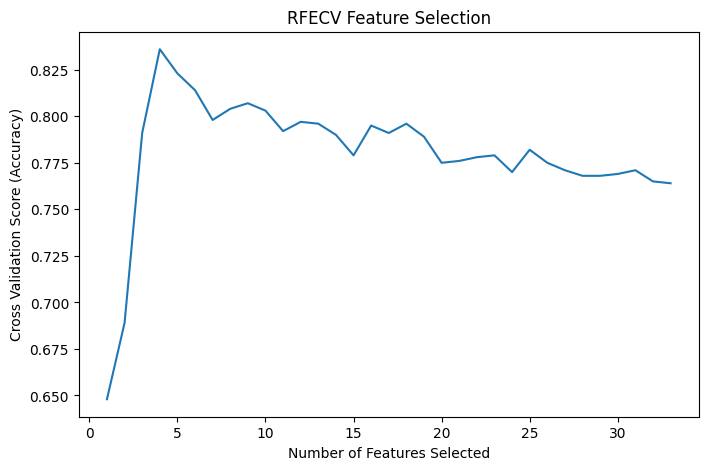

In [25]:
X = df2.drop(columns=['fraud_reported'])
y = df2['fraud_reported']

rfecv = RFECV(estimator=RandomForestClassifier(random_state=42), step=1, cv=5, scoring='accuracy', n_jobs=-1)
rfecv.fit(X, y)
print("Optimal number of features:", rfecv.n_features_)
selected_features = X.columns[rfecv.support_]
print("Selected features:", list(selected_features))
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross Validation Score (Accuracy)")
plt.title("RFECV Feature Selection")
plt.show()


In [26]:
X_selected = X[selected_features]

X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [27]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_res, y_train_res)
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

fpr, tpr, _ = roc_curve(y_test, y_proba)
cm = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:\n", cm)

              precision    recall  f1-score   support

           0       0.93      0.85      0.89       151
           1       0.64      0.80      0.71        49

    accuracy                           0.84       200
   macro avg       0.78      0.83      0.80       200
weighted avg       0.86      0.84      0.85       200

ROC-AUC Score: 0.8236923908636302
Confusion Matrix:
 [[129  22]
 [ 10  39]]


In [28]:
# Hyperparameter tuning to minimize errors FP & FN
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1', 
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train_res, y_train_res)
print("Best parameters:", grid_search.best_params_)

KeyboardInterrupt: 

In [ ]:
best_params = grid_search.best_params_
rf_best = RandomForestClassifier(**best_params, random_state=42)
rf_best.fit(X_train_res, y_train_res)
y_pred_best = rf_best.predict(X_test)
cm_best = confusion_matrix(y_test, y_pred_best)
print("Best parameters from GridSearchCV:", best_params)
print("Confusion Matrix with GridSearchCV best parameters:\n", cm_best)

Best parameters from GridSearchCV: {'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Confusion Matrix with GridSearchCV best parameters:
 [[127  24]
 [  9  40]]


In [ ]:
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    rf, param_distributions=param_dist, n_iter=20, scoring='f1',
    cv=5, n_jobs=-1, random_state=42
)
random_search.fit(X_train_res, y_train_res)
best_rf = random_search.best_estimator_
print("Best parameters:", random_search.best_params_)

Best parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20, 'class_weight': 'balanced'}


In [ ]:
y_pred_rf = best_rf.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)
y_proba = best_rf.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC Score with best parameters:", roc_auc_score(y_test, y_proba))
print("Confusion Matrix with best parameters:\n", cm_rf)

              precision    recall  f1-score   support

           0       0.93      0.85      0.89       151
           1       0.64      0.80      0.71        49

    accuracy                           0.84       200
   macro avg       0.78      0.83      0.80       200
weighted avg       0.86      0.84      0.85       200

ROC-AUC Score with best parameters: 0.8225435869712124
Confusion Matrix with best parameters:
 [[129  22]
 [ 10  39]]


In [ ]:
threshold = 0.3
y_pred_thresh = (y_proba >= threshold)
cm = confusion_matrix(y_test, y_pred_thresh)
print("Confusion Matrix at threshold", threshold, ":\n", cm)

Confusion Matrix at threshold 0.3 :
 [[114  37]
 [  6  43]]


In [ ]:
# Train RandomForest with your custom hyperparameters
rf_custom = RandomForestClassifier(
    n_estimators=150,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)
rf_custom.fit(X_train_res, y_train_res)
y_pred_custom = rf_custom.predict(X_test)

# Confusion matrix and accuracy
cm_custom = confusion_matrix(y_test, y_pred_custom)
accuracy_custom = rf_custom.score(X_test, y_test)
print("Confusion Matrix:\n", cm_custom)
print("Accuracy:", accuracy_custom)


Confusion Matrix:
 [[128  23]
 [  9  40]]
Accuracy: 0.84


- Therefore, Confusion Matrix 2 is likely the "good" one based on prioritizing the reduction of missed fraud cases.
- Comparison and Conclusion:

In fraud detection, minimizing False Negatives (FN) is typically the most critical goal, as missing fraud cases can be very costly. Therefore, we should prioritize the matrix with the lowest FN.

Matrix 1: FN = 9
Matrix 2: FN = 6
Matrix 3: FN = 10
Matrix 2 has the lowest number of False Negatives (6), indicating it missed the fewest actual fraud cases among the three models.

While Matrix 2 has a slightly lower precision and accuracy compared to Matrix 1 and 3, its significantly better recall (0.878 vs ~0.816 and ~0.796) makes it the most desirable in a typical fraud detection scenario where the cost of a false negative is much higher than the cost of a false positive.

In [ ]:
# X = df2.drop(columns=['fraud_reported'])
# y = df2['fraud_reported']

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=42, stratify=y
# )

# X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# rf_sel = RandomForestClassifier(random_state=42)
# rf_sel.fit(X_train_res, y_train_res)
# y_pred_sel = rf_sel.predict(X_test)
# y_proba_sel = rf_sel.predict_proba(X_test)[:, 1]

# print("Classification Report (selected features):")
# print(classification_report(y_test, y_pred_sel))
# print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_sel))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_sel))


# param_grid_sel = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 5, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'class_weight': [None, 'balanced']
# }
# grid_search_sel = GridSearchCV(
#     estimator=RandomForestClassifier(random_state=42),
#     param_grid=param_grid_sel,
#     scoring='f1',
#     cv=5,
#     n_jobs=-1
# )
# grid_search_sel.fit(X_train_res, y_train_res)
# print("Best parameters (selected features):", grid_search_sel.best_params_)

# # Evaluate best model
# rf_best_sel = RandomForestClassifier(**grid_search_sel.best_params_, random_state=42)
# rf_best_sel.fit(X_train_res, y_train_res)
# y_pred_best_sel = rf_best_sel.predict(X_test)
# y_proba_best_sel = rf_best_sel.predict_proba(X_test)[:, 1]
# print("Classification Report (best params, selected features):")
# print(classification_report(y_test, y_pred_best_sel))
# print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_best_sel))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best_sel))